In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_score

In [230]:
gtmegye = pd.read_csv('GTrend_megye_aranyok1118.csv')

In [231]:
# no need with László's files, necessary with Miklós's output:
#gtmelt = pd.melt(gtmegye, id_vars=['honap','megye'], value_vars=['fidesz','lmp','mszp','jobbik','egyutt','momentum','pm','dk'])
#gtmelt.rename(columns={'variable':'part','value':'search_intensity'},inplace=True)
gtmelt = gtmegye.rename(columns={'Month':'honap','party':'szervezet'})

In [232]:
# need to ignore 2010 for now
gtmelt14 = gtmelt.loc[gtmelt['honap'].isin(['2014-01','2014-02','2014-03'])]

In [233]:
# not compatible with 2010
gtmelt14_nobal = gtmelt14.loc[~gtmelt14['szervezet'].isin(['mszp','egyutt','dk','pm'])]
gtmelt14_bal = gtmelt14.loc[gtmelt14['szervezet'].isin(['mszp','egyutt','dk','pm'])]

In [234]:
gtmelt14_bal = gtmelt14_bal.groupby(['honap','megye'])['search_intensity'].sum().reset_index()

In [235]:
gtmelt14_bal['szervezet'] = 'baloldal'

In [236]:
gtmelt14 = gtmelt14_nobal.append(gtmelt14_bal)

In [237]:
gtmelt14['ev'],gtmelt14['ho']=gtmelt14['honap'].str.split('-').str

In [238]:
gtmelt14.head()

,honap,megye,search_intensity,szervezet,ev,ho
5762,2014-01,1,0.240876,fidesz,2014,01
5763,2014-01,1,0.182482,jobbik,2014,01
5764,2014-01,1,0.072993,lmp,2014,01
5765,2014-01,1,0.000000,momentum,2014,01
5770,2014-01,2,0.154362,fidesz,2014,01


In [239]:
gtmelt14.drop(columns='honap',inplace=True)

In [240]:
gt14_hopivot = gtmelt14.pivot_table(values='search_intensity', index=['ev', 'szervezet','megye'], columns='ho').reset_index()

## Missing:
-    MDF search for 2010 — de ha úgyis újra, akkor szűkebb időtartamra, és a két csúcspártot vagy a legkisebb nagypártot tartani a kispártosban?
-    civilek, mszdp, mp stb? UPDATE: max a civilek kellenek
-    set search intensity for dk to 0 before oct 22, 2011, set pm to 0 before feb 17, 2013, set együtt to 0 before oct 26, 2012?
-    kétfarkú?
-    megyei összesítés és arányok 2010
-    ridge vagy súlyozott ridge?

## 2010-es listás adatok -- SKIP

In [241]:
# listas10 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/2010/listas.csv')

In [242]:
# listas10.head()

In [243]:
# part_to_szervezet = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/2010/szervezet_shortname.csv')

In [244]:
# part_to_szervezet.head()

In [245]:
# listas10 = listas10.merge(part_to_szervezet,left_on='part',right_on='id',copy=False)

In [246]:
# listas10 = listas10[~listas10['szervezet'].isin(['miép','mp','mszdp'])]

In [247]:
# listas10['megye']=listas10['id'].str.extract('M(\d\d)/.*').astype('uint8')

In [248]:
# listas10megyei = listas10.groupby(['megye','szervezet'])['szavazat'].sum()#.reset_index()

In [249]:
# listas10megyeiaranyok = listas10megyei.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

In [250]:
# listas10megyeiaranyok.head()

## 2014-es listás adatok

In [251]:
listas14 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/jelolt/listas.csv')

In [252]:
part_to_szervezet14 = pd.read_csv('/Users/laszlo.sandor/Documents/github/106/adat/jelolt/szervezet_shortname_2014.csv')

In [253]:
part_to_szervezet14.head()

,szervezet,id
0,mcp,1
1,eladó,2
2,seres,3
3,fkgp,4
4,údp,5


In [254]:
listas14 = listas14.merge(part_to_szervezet14,left_on='part',right_on='id',copy=False)

In [255]:
listas14.head()

,szavazokor,part,szavazat,szervezet,id
0,M01/T001/001,1,0,mcp,1
1,M01/T001/002,1,2,mcp,1
2,M01/T001/003,1,0,mcp,1
3,M01/T001/004,1,0,mcp,1
4,M01/T001/005,1,0,mcp,1


In [256]:
listas14 = listas14[~listas14['szervezet'].isin(['mcp','eladó','seres','fkgp','údp','sem','jesz','úmp','mp','szd','kti','együtt','zp','öf','total'])]

In [257]:
listas14['megye']=listas14['szavazokor'].str.extract('M(\d\d)/.*').astype('uint8')

/Users/laszlo.sandor/miniconda3/envs/idp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [258]:
listas14megyei = listas14.groupby(['megye','szervezet'])['szavazat'].sum()

In [259]:
listas14megyeiaranyok = listas14megyei.groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index()

In [260]:
listas14megyeiaranyok.head()

,megye,szervezet,szavazat
0,1,baloldal,0.381925
1,1,fidesz,0.399956
2,1,jobbik,0.125411
3,1,lmp,0.092708
4,2,baloldal,0.294771


In [261]:
ridgetable14 = listas14megyeiaranyok.merge(gt14_hopivot,on=['megye','szervezet'],validate='1:1',copy=False)

In [263]:
polls2014 = pd.read_csv('2014polls.csv',engine='c')
ridgetable14 = ridgetable14.merge(polls2014,on=['szervezet'],validate='m:1',copy=False)
ridgetable14['ave_polls']=ridgetable14['ave_polls']/100

In [264]:
megyevoters = pd.read_csv('megyevoters.csv',engine='c')
megyedict = {'bacskiskun':3,'baranya':2,'baz':5,'bekes':4,'budapest':1,'csongrad':6,'fejer':7,'gyms':8,'hb':9,'heves':10,'jnsz':11,'ke':12,'nograd':13,'pest':14,'somogy':15,'szszb':16,'tolna':17,'vas':18,'veszprem':19,'zala':20}
megyevoters['megye'].replace(megyedict,inplace=True)
megyevoters['voters']=megyevoters['voters']/megyevoters['voters'].sum()
ridgetable14 = ridgetable14.merge(megyevoters,on=['megye'],validate='m:1',copy=False)

## Fitting a ridge model
Considerations:
    - use also average poll numbers from January?
    - keep all three Google Search variables?

In [265]:
X = ridgetable14[['01','02','03','ave_polls']]
y = ridgetable14['szavazat']
w = ridgetable14['voters']/ridgetable14['voters'].mean()
groups = ridgetable14['megye']

In [266]:
alphas = np.logspace(-10, 2, 2000)

In [267]:
model1 = linear_model.RidgeCV(alphas, fit_intercept=False, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=True)
model1.fit(X,y,sample_weight=w)

RidgeCV(alphas=array([1.00000e-10, 1.01392e-10, ..., 9.86273e+01, 1.00000e+02]),
    cv=None, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [268]:
model1.coef_

array([-0.05020815,  0.06009836,  0.15201181,  0.78588069])

In [269]:
model1.alpha_

0.05132809872422098

## Rerun CV with proper leave-one-group-out cross-validation but weird weighting

In [270]:
logo = LeaveOneGroupOut()

In [271]:
model2 = linear_model.RidgeCV(alphas, fit_intercept=False, normalize=False, scoring=None, cv=logo.split(X, y, groups=groups), gcv_mode=None)#, store_cv_values=True)
model2.fit(X,y,sample_weight=w)

RidgeCV(alphas=array([1.00000e-10, 1.01392e-10, ..., 9.86273e+01, 1.00000e+02]),
    cv=<generator object BaseCrossValidator.split at 0x303a34d4c0>,
    fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [272]:
model2.coef_

array([-0.0695079 ,  0.05363325,  0.15562762,  0.80805572])

In [273]:
model2.alpha_

0.017706146858616094

In [274]:
model2eval = linear_model.Ridge(model2.alpha_, fit_intercept=False, normalize=False)
scores = cross_val_score(model2eval, X, y, cv=logo.split(X, y, groups=groups),scoring='neg_mean_squared_error')

In [275]:
scores.mean()

-0.0027892465539526706

In [276]:
2*np.sqrt(-scores.mean())

0.10562663592016307

## Evaluating MSE as a function of the regularization -- This only works after store_cv_values, which only works with simple LOO cross-validation

In [277]:
mses_by_alphas = model1.cv_values_.mean(axis=0)

In [278]:
mses_by_alphas.min()

0.002989332646123781

In [279]:
2*np.sqrt(mses_by_alphas.min())

0.1093495797179629

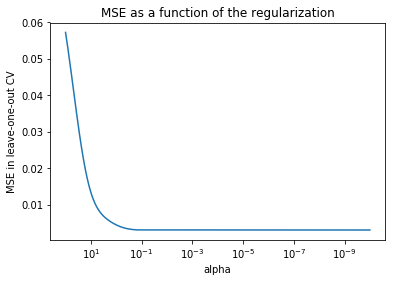

In [280]:
# #############################################################################
# Display results 

ax = plt.gca()

ax.plot(alphas, mses_by_alphas)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('MSE in leave-one-out CV')
plt.title('MSE as a function of the regularization')
plt.axis('tight')
plt.show()

### Explore coefs in terms of regularization

In [ ]:
# #############################################################################
# Compute paths

n_alphas = 200
alphas = np.logspace(-10, 2, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

# #############################################################################
# Display results

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

## Check correlation patterns of regressors, maybe average the correlated ones?

In [281]:
def wm(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)
def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wm(x, w)) * (y - wm(y, w))) / np.sum(w)
def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [282]:
wcorr(ridgetable14['01'],ridgetable14['02'],ridgetable14['voters'])

0.7851418504128099

In [283]:
wcorr(ridgetable14['01'],ridgetable14['03'],ridgetable14['voters'])

0.5551497767488874

In [284]:
wcorr(ridgetable14['02'],ridgetable14['03'],ridgetable14['voters'])

0.6915313119299836

In [285]:
wcorr(ridgetable14['01'],ridgetable14['ave_polls'],ridgetable14['voters'])

0.6852724104544767

In [286]:
wcorr(ridgetable14['02'],ridgetable14['ave_polls'],ridgetable14['voters'])

0.6217556579019654

In [287]:
wcorr(ridgetable14['03'],ridgetable14['ave_polls'],ridgetable14['voters'])

0.4116345630597129

## Rerun LOO CV-d but weighted model with fewer variables

In [288]:
X3 = ridgetable14[['03','ave_polls']]
model4 = linear_model.RidgeCV(alphas, fit_intercept=False, normalize=False, scoring=None, cv=None, gcv_mode=None, store_cv_values=True)
model4.fit(X3,y,sample_weight=w)

RidgeCV(alphas=array([1.00000e-10, 1.01392e-10, ..., 9.86273e+01, 1.00000e+02]),
    cv=None, fit_intercept=False, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [289]:
model4.coef_

array([0.15628376, 0.79292027])

In [290]:
model4.alpha_

0.01288412790380471

In [291]:
mses_by_alphas = model4.cv_values_.mean(axis=0)

In [292]:
mses_by_alphas.min()

0.0028532857091797268

In [293]:
2*np.sqrt(mses_by_alphas.min())

0.10683231176343096

## Rerun properly CV-d (weighted?) model with fewer variables

In [294]:
model3 = linear_model.RidgeCV(alphas, fit_intercept=False, normalize=False, scoring=None, cv=logo.split(X, y, groups=groups), gcv_mode=None)#, store_cv_values=True)
model3.fit(X3,y,sample_weight=w)

RidgeCV(alphas=array([1.00000e-10, 1.01392e-10, ..., 9.86273e+01, 1.00000e+02]),
    cv=<generator object BaseCrossValidator.split at 0x2f29478360>,
    fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [295]:
model3eval = linear_model.Ridge(model3.alpha_, fit_intercept=False, normalize=False)
scores = cross_val_score(model3eval, X3, y, cv=logo.split(X3, y, groups=groups),scoring='neg_mean_squared_error')

In [296]:
scores.mean()

-0.002737348802904319

In [297]:
2*np.sqrt(-scores.mean())

0.10463935785170547

In [298]:
model3.coef_

array([0.17039601, 0.77626911])

In [299]:
model3.alpha_

0.07151995188338064

# 2018 prediction

In [300]:
gtmelt18 = gtmelt.loc[gtmelt['honap'].isin(['2018-01','2018-02','2018-03'])]
gtmelt18_nobal = gtmelt18.loc[~gtmelt18['szervezet'].isin(['mszp','pm'])]
gtmelt18_bal = gtmelt18.loc[gtmelt18['szervezet'].isin(['mszp','pm'])]

In [301]:
gtmelt18_bal = gtmelt18_bal.groupby(['honap','megye'])['search_intensity'].sum().reset_index()

In [302]:
gtmelt18_bal['szervezet'] = 'mszp-p'

In [303]:
gtmelt18 = gtmelt18_nobal.append(gtmelt18_bal)

In [304]:
gtmelt18['ev'],gtmelt18['ho']=gtmelt18['honap'].str.split('-').str

In [305]:
gtmelt18.drop(columns='honap',inplace=True)

In [306]:
gt18_hopivot = gtmelt18.pivot_table(values='search_intensity', index=['ev', 'szervezet','megye'], columns='ho').reset_index()

In [307]:
polls2018 = pd.read_csv('2018polls.csv',engine='c')

In [322]:
ridgetable18 = gt18_hopivot.merge(polls2018,on=['szervezet'],validate='m:1',copy=False)

In [323]:
ridgetable18['ave_polls']=ridgetable18['ave_polls']/100
ridgetable18 = ridgetable18.merge(megyevoters,on=['megye'],validate='m:1',copy=False)

In [324]:
predX3 = ridgetable18[['03','ave_polls']]

In [325]:
predict18 = ridgetable18[['szervezet','megye']].copy()

In [326]:
predict18['listas_elorejelzes'] = model3.predict(predX3)

In [327]:
megyenamedict = {v: k for k, v in megyedict.items()}
predict18['megyenevek'] = predict18['megye']
predict18['megyenevek'].replace(megyenamedict,inplace=True)

In [330]:
predict18.to_csv('ridge_elorejelzes.csv')